<a href="https://colab.research.google.com/github/SinaYademellat/AIC_tmp/blob/main/A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import - test_Vgg_16 - Runt_It


## import

In [109]:
from tabulate import tabulate

import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn


from torchvision.models import vgg16, VGG16_Weights
from torchsummary import summary
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## myClass

In [110]:
class test_Vgg_16:
  def __init__(self,show_summary=True):
      self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      self.model = vgg16(weights=VGG16_Weights.DEFAULT).to(device)
      if(show_summary):
        summary(self.model, input_size=(3, 224, 224))

  def Analysisـofـlayerـnumber_L (self,L , Debug_ = True):
      self.curent_Layer_info = self.model.features[L]
      self.curent_weights    = self.curent_Layer_info.weight.data
      self.curent_bias       = self.curent_Layer_info.bias.data

      if(Debug_):
        print('>>'*12 ,'def: Analysisـofـlayerـnumber_L ',"<<"*12)
        print('curent_Layer_info: ',self.curent_Layer_info)
        print('curent_weights: '   ,self.curent_weights.shape)
        print('curent_weights: '   ,self.curent_bias.shape)
        print('-'*50)

  def Apply_convolution(self,input_tensor , Debug_ = True):
    with torch.no_grad():
        self.output = F.conv2d(input  = input_tensor,
                               weight = self.curent_weights,
                               bias   = self.curent_bias,
                               stride = self.curent_Layer_info.stride, padding= self.curent_Layer_info.padding)

    if(Debug_):
        print('>>'*12 ,'def: Apply_convolution ',"<<"*12)
        print('shape: ', self.output.shape)
        print('-'*50)

  def Visualize__curentLayer_output_All_channel(self,i_batch=0, title="a"):
      size_ = self.output.shape[1]
      if(size_%4==0):
        tmp2 = size_ // 4
        z = 0

        fig, axs = plt.subplots(4, tmp2, figsize=(size_//2, 10))
        plt.suptitle(title, fontsize=16)


        for i in range(4):
            for j in range(tmp2):
                idx = i * 32 + j
                axs[i, j].imshow(self.output[i_batch, z].cpu(), cmap='gray')
                axs[i, j].axis('off')
                z+=1

        plt.tight_layout()
        plt.show()

      elif(size_%3==0):
            tmp2 = size_ // 3
            z = 0

            fig, axs = plt.subplots(4, tmp2, figsize=(size_//2, 10))
            plt.suptitle(title, fontsize=16)

            for i in range(3):
                for j in range(tmp2):
                    idx = i * 32 + j
                    axs[i, j].imshow(self.output[i_batch, z].cpu(), cmap='gray')
                    axs[i, j].axis('off')
                    z+=1

            plt.tight_layout()
            plt.show()
      else:
        print(":(")

  def Loop_time(self,U_index, input_img_is , show_flag = True , debug_print =False):
    print('>>'*12 ,'def: Loop_time ',"<<"*12)
    result_is = []

    for index_is , layer in enumerate(self.model.features):

          if(debug_print):
            print(f' {index_is} ) input is :  -> {input_img_is.shape}')

          if(index_is >= U_index):
                return result_is
                break

          if isinstance(layer, nn.Conv2d):
              self.Analysisـofـlayerـnumber_L(index_is,Debug_=False)

              if(debug_print):
                print('conv2d')

              self.Apply_convolution( input_img_is,Debug_=False )
              # ---------------
              result_is.append(self.output)
              # ---------------
              if(show_flag ):
                  self.Visualize__curentLayer_output_All_channel(title=f'Conv2d-{index_is}')

          elif isinstance(layer, nn.ReLU):

              if(debug_print):
                  print('relu'
                  )
              input_img_is = F.relu(self.output, inplace=True)

          elif isinstance(layer, nn.MaxPool2d):

              if(debug_print):
                  print('maxpool2d')

              pool = nn.MaxPool2d(kernel_size = self.model.features[index_is].kernel_size,
                                  stride      = self.model.features[index_is].stride,
                                  padding     = self.model.features[index_is].padding,
                                  dilation    = self.model.features[index_is].dilation
                                  )

              input_img_is = pool(input_img_is)
          else :
            print(':(')
            break


    print('-'*30 , 'Loop_time' , '-'*30)
    return result_is


## Runt_It

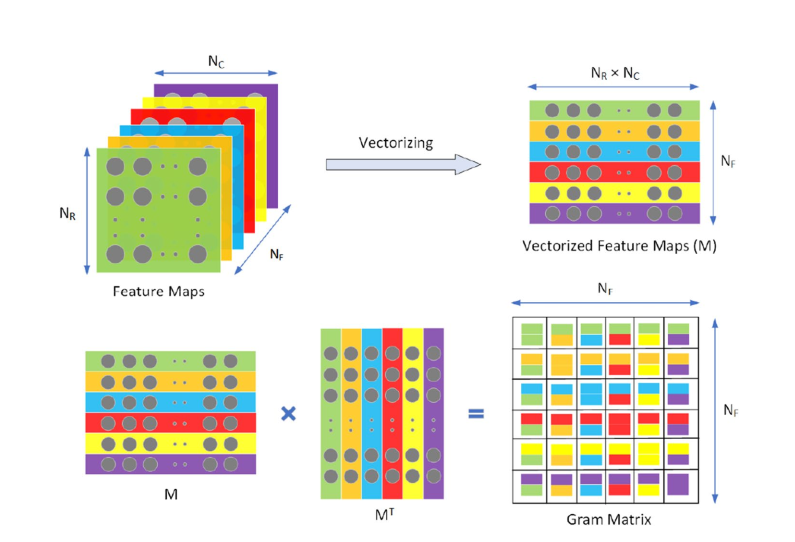

In [111]:
def Runt_It(img_path , debug_print_result_fun_is=False):
      # فراخوانی کلاس
      A = test_Vgg_16(False)
      # ----------------------------------------------- >> آماده سازی برای وی جی جی ۱۶
      image = Image.open(img_path).convert('RGB')
      transform = transforms.Compose([
          transforms.Resize((224, 224)),
          transforms.ToTensor()
      ])
      input_tensor = transform(image).unsqueeze(0)
      print(input_tensor.shape)
      # ----------------------------------------------- >>  خروجی لیست تمام لایه های کانولوشنی هست
      TMP_Result_is = A.Loop_time(U_index=40,input_img_is=input_tensor, show_flag=False , debug_print = False)
      print("len(len(TMP_Result_is)) ", len(TMP_Result_is))
      # ----------------------------------------------- >> قرار شد خروجی هر لایه کانولوشنی را مثل یک ماتریس تولید کنیم همان مثال که استاد تو تلگرام برام فرستاده
      test_ = []
      for idx, i in enumerate(TMP_Result_is):
          shape = i[0].shape
          tmp = i[0].view(shape[0],-1)
          print(f"[{idx:2}] {str(shape):27} ==>  (r,c) : ({shape[0]:3} , {shape[1]*shape[2]:<5}) =(?)= {tmp.shape}")
          test_.append(tmp)
      # ----------------------------------------------- >>‌ بعد از ضرب همین ماتریس در معکوس خودش قسمت بالا مثلثی را در یک لیست ذخیره میکنم
      print('>'*12,'result_fun_is --> triu_indices','<'*12)
      result_fun_is = []
      for test_i in test_:

            Result_multiplication= test_i@test_i.T
            triu_indices = torch.triu_indices(Result_multiplication.shape[0] , Result_multiplication.shape[1])
            upper_v = Result_multiplication[triu_indices[0], triu_indices[1]]
            result_fun_is.append(upper_v)
            if(debug_print_result_fun_is):
              print(Result_multiplication.shape)
              print(type(upper_v) , upper_v.shape)
              print('-'*12)
      # ----------------------------------------------- >> یک لیست به تعداد لایه های کانولوشنی که هر عنصر آن یک برداری هست که بیانگر بالا مثلث فیچرمپ همان لایه ضرب ماتریسی در ترانهاد آن
      return result_fun_is

# Test

## test 1

### فراخوانی

In [112]:
I01_BMP = Runt_It('/content/I01.BMP')
print('*'*20)
I01_ـ01_1_BMP = Runt_It('/content/I01_01_1.bmp')
print('*'*20)
I01_ـ01_2_BMP = Runt_It('/content/i01_01_2.bmp')
print('*'*20)


torch.Size([1, 3, 224, 224])
>>>>>>>>>>>>>>>>>>>>>>>> def: Loop_time  <<<<<<<<<<<<<<<<<<<<<<<<
------------------------------ Loop_time ------------------------------
len(len(TMP_Result_is))  13
[ 0] torch.Size([64, 224, 224])  ==>  (r,c) : ( 64 , 50176) =(?)= torch.Size([64, 50176])
[ 1] torch.Size([64, 224, 224])  ==>  (r,c) : ( 64 , 50176) =(?)= torch.Size([64, 50176])
[ 2] torch.Size([128, 112, 112]) ==>  (r,c) : (128 , 12544) =(?)= torch.Size([128, 12544])
[ 3] torch.Size([128, 112, 112]) ==>  (r,c) : (128 , 12544) =(?)= torch.Size([128, 12544])
[ 4] torch.Size([256, 56, 56])   ==>  (r,c) : (256 , 3136 ) =(?)= torch.Size([256, 3136])
[ 5] torch.Size([256, 56, 56])   ==>  (r,c) : (256 , 3136 ) =(?)= torch.Size([256, 3136])
[ 6] torch.Size([256, 56, 56])   ==>  (r,c) : (256 , 3136 ) =(?)= torch.Size([256, 3136])
[ 7] torch.Size([512, 28, 28])   ==>  (r,c) : (512 , 784  ) =(?)= torch.Size([512, 784])
[ 8] torch.Size([512, 28, 28])   ==>  (r,c) : (512 , 784  ) =(?)= torch.Size([512, 7

### خروجی نهایی

In [113]:

data = []
for i in range(13):
      reference = I01_BMP[i]
      d_01_1    = I01_ـ01_1_BMP[i]
      d_01_2    = I01_ـ01_2_BMP[i]
      # ------------ Norm --------------
      reference_norm = F.normalize(reference, dim=0)
      d_01_1_norm    =  F.normalize(d_01_1, dim=0)
      d_01_2_norm    = F.normalize(d_01_2, dim=0)

      cosine_distance_pqrt_1 = 1 - torch.dot(reference_norm, d_01_1_norm)
      cosine_distance_pqrt_2 = 1 - torch.dot(reference_norm, d_01_2_norm)

      row = [i, cosine_distance_pqrt_1, cosine_distance_pqrt_2]
      data.append(row)

print(tabulate(data, headers=["index", "D1", "D2"], floatfmt=".5f"))


  index       D1       D2
-------  -------  -------
      0  0.00000  0.00000
      1  0.00001  0.00004
      2  0.00012  0.00042
      3  0.00033  0.00111
      4  0.00071  0.00218
      5  0.00091  0.00285
      6  0.00098  0.00316
      7  0.00105  0.00313
      8  0.00116  0.00343
      9  0.00093  0.00267
     10  0.00087  0.00214
     11  0.00090  0.00193
     12  0.00577  0.00820


## Test_2 : New_fun

In [114]:
def Run_img_and_di(reference_path , Destruction_path_list:list=[] , conv_n = 13):

      # ------------------------------
      print('>'*20 , ' Runt_It ' , '<'*20)
      reference = Runt_It(reference_path)
      tmp_Destruction =[]
      for destruction_path in Destruction_path_list:
          tmp = Runt_It(destruction_path)
          tmp_Destruction.append(tmp)
      print('='*20)
      # ------------------------------

      return  reference ,tmp_Destruction

In [115]:
AA =[]
RR , AA  = Run_img_and_di('/content/I01.BMP' , ['/content/I01_01_1.bmp','/content/i01_01_2.bmp','/content/i01_01_2.bmp'])

>>>>>>>>>>>>>>>>>>>>  Runt_It  <<<<<<<<<<<<<<<<<<<<
torch.Size([1, 3, 224, 224])
>>>>>>>>>>>>>>>>>>>>>>>> def: Loop_time  <<<<<<<<<<<<<<<<<<<<<<<<
------------------------------ Loop_time ------------------------------
len(len(TMP_Result_is))  13
[ 0] torch.Size([64, 224, 224])  ==>  (r,c) : ( 64 , 50176) =(?)= torch.Size([64, 50176])
[ 1] torch.Size([64, 224, 224])  ==>  (r,c) : ( 64 , 50176) =(?)= torch.Size([64, 50176])
[ 2] torch.Size([128, 112, 112]) ==>  (r,c) : (128 , 12544) =(?)= torch.Size([128, 12544])
[ 3] torch.Size([128, 112, 112]) ==>  (r,c) : (128 , 12544) =(?)= torch.Size([128, 12544])
[ 4] torch.Size([256, 56, 56])   ==>  (r,c) : (256 , 3136 ) =(?)= torch.Size([256, 3136])
[ 5] torch.Size([256, 56, 56])   ==>  (r,c) : (256 , 3136 ) =(?)= torch.Size([256, 3136])
[ 6] torch.Size([256, 56, 56])   ==>  (r,c) : (256 , 3136 ) =(?)= torch.Size([256, 3136])
[ 7] torch.Size([512, 28, 28])   ==>  (r,c) : (512 , 784  ) =(?)= torch.Size([512, 784])
[ 8] torch.Size([512, 28, 28])  

In [116]:
print('index ',end=' '*5)
for j in range(len(AA)):
  print(f' -d{j+1} ' ,end=' '*2)
print()


data = []
for i in range(13):
      reference = RR[i]
      reference_norm = F.normalize(reference, dim=0)

      print(f"({i}) --> ",end='')
      for j in range(len(AA)):
          I01_ـ01_1_BMP = AA[j]
          d_01_1    = I01_ـ01_1_BMP[i]
          d_01_1_norm    =  F.normalize(d_01_1, dim=0)
          cosine_distance_pqrt_1 = 1 - torch.dot(reference_norm, d_01_1_norm)
          print( f"{cosine_distance_pqrt_1:.5f} ",end='  ')
      print()


index       -d1    -d2    -d3   
(0) --> 0.00000   0.00000   0.00000   
(1) --> 0.00001   0.00004   0.00004   
(2) --> 0.00012   0.00042   0.00042   
(3) --> 0.00033   0.00111   0.00111   
(4) --> 0.00071   0.00218   0.00218   
(5) --> 0.00091   0.00285   0.00285   
(6) --> 0.00098   0.00316   0.00316   
(7) --> 0.00105   0.00313   0.00313   
(8) --> 0.00116   0.00343   0.00343   
(9) --> 0.00093   0.00267   0.00267   
(10) --> 0.00087   0.00214   0.00214   
(11) --> 0.00090   0.00193   0.00193   
(12) --> 0.00577   0.00820   0.00820   


به شکل جدول

In [117]:
table = []

for i in range(13):
    reference = RR[i]
    reference_norm = F.normalize(reference, dim=0)

    row = [i]

    for j in range(len(AA)):
        I01_ـ01_1_BMP = AA[j]
        d_01_1 = I01_ـ01_1_BMP[i]
        d_01_1_norm = F.normalize(d_01_1, dim=0)
        cosine_distance = 1 - torch.dot(reference_norm, d_01_1_norm)
        row.append(float(cosine_distance))
    table.append(row)

headers = ["Index"] + [f"d{j+1}" for j in range(len(AA))]

print(tabulate(table, headers=headers, floatfmt=".5f", tablefmt="fancy_grid"))

╒═════════╤═════════╤═════════╤═════════╕
│   Index │      d1 │      d2 │      d3 │
╞═════════╪═════════╪═════════╪═════════╡
│       0 │ 0.00000 │ 0.00000 │ 0.00000 │
├─────────┼─────────┼─────────┼─────────┤
│       1 │ 0.00001 │ 0.00004 │ 0.00004 │
├─────────┼─────────┼─────────┼─────────┤
│       2 │ 0.00012 │ 0.00042 │ 0.00042 │
├─────────┼─────────┼─────────┼─────────┤
│       3 │ 0.00033 │ 0.00111 │ 0.00111 │
├─────────┼─────────┼─────────┼─────────┤
│       4 │ 0.00071 │ 0.00218 │ 0.00218 │
├─────────┼─────────┼─────────┼─────────┤
│       5 │ 0.00091 │ 0.00285 │ 0.00285 │
├─────────┼─────────┼─────────┼─────────┤
│       6 │ 0.00098 │ 0.00316 │ 0.00316 │
├─────────┼─────────┼─────────┼─────────┤
│       7 │ 0.00105 │ 0.00313 │ 0.00313 │
├─────────┼─────────┼─────────┼─────────┤
│       8 │ 0.00116 │ 0.00343 │ 0.00343 │
├─────────┼─────────┼─────────┼─────────┤
│       9 │ 0.00093 │ 0.00267 │ 0.00267 │
├─────────┼─────────┼─────────┼─────────┤
│      10 │ 0.00087 │ 0.00214 │ 0.

# main

In [118]:
def Run_reference_and_Destruction(reference_path , Destruction_path_list:list=[] , conv_n = 13):

      # ------------------------------
      print('>'*20 , ' Runt_It ' , '<'*20)
      reference_list = Runt_It(reference_path)
      tmp_Destruction =[]
      for destruction_path in Destruction_path_list:
          tmp = Runt_It(destruction_path)
          tmp_Destruction.append(tmp)
      print('='*20)
      # ------------------------------
      # return  reference_list ,tmp_Destruction
      # ======================= جدول
      table = []
      # for i in range(conv_n):
      for i in range(len(reference_list)):
          reference = reference_list[i]
          reference_norm = F.normalize(reference, dim=0)
          row = [i]

          for j in range(len(tmp_Destruction)):
              I01_ـ01_1_BMP = tmp_Destruction[j]
              d_01_1 = I01_ـ01_1_BMP[i]
              d_01_1_norm = F.normalize(d_01_1, dim=0)
              cosine_distance = 1 - torch.dot(reference_norm, d_01_1_norm)
              row.append(float(cosine_distance))
          table.append(row)

      headers = ["Index"] + [f"d{j+1}" for j in range(len(tmp_Destruction))]

      print(tabulate(table, headers=headers, floatfmt=".9f", tablefmt="fancy_grid"))


## test1

In [119]:
Run_reference_and_Destruction('/content/I01.BMP' , ['/content/I01_01_1.bmp','/content/i01_01_2.bmp','/content/i01_01_2.bmp'])

>>>>>>>>>>>>>>>>>>>>  Runt_It  <<<<<<<<<<<<<<<<<<<<
torch.Size([1, 3, 224, 224])
>>>>>>>>>>>>>>>>>>>>>>>> def: Loop_time  <<<<<<<<<<<<<<<<<<<<<<<<
------------------------------ Loop_time ------------------------------
len(len(TMP_Result_is))  13
[ 0] torch.Size([64, 224, 224])  ==>  (r,c) : ( 64 , 50176) =(?)= torch.Size([64, 50176])
[ 1] torch.Size([64, 224, 224])  ==>  (r,c) : ( 64 , 50176) =(?)= torch.Size([64, 50176])
[ 2] torch.Size([128, 112, 112]) ==>  (r,c) : (128 , 12544) =(?)= torch.Size([128, 12544])
[ 3] torch.Size([128, 112, 112]) ==>  (r,c) : (128 , 12544) =(?)= torch.Size([128, 12544])
[ 4] torch.Size([256, 56, 56])   ==>  (r,c) : (256 , 3136 ) =(?)= torch.Size([256, 3136])
[ 5] torch.Size([256, 56, 56])   ==>  (r,c) : (256 , 3136 ) =(?)= torch.Size([256, 3136])
[ 6] torch.Size([256, 56, 56])   ==>  (r,c) : (256 , 3136 ) =(?)= torch.Size([256, 3136])
[ 7] torch.Size([512, 28, 28])   ==>  (r,c) : (512 , 784  ) =(?)= torch.Size([512, 784])
[ 8] torch.Size([512, 28, 28])  

## test 2

### colab

In [120]:
# from google.colab import drive
# drive.mount('/content/drive')
# ! unzip "P"


### org1 --> 18

In [122]:
reference_path_is = '/content/download/org1.png'
Destruction_path_list = []
for i in range(6):
  TMP = f'/content/download/org1_18_{i+1}.png'
  print(TMP)
  Destruction_path_list.append(TMP)

Run_reference_and_Destruction(reference_path_is ,Destruction_path_list)


/content/download/org1_18_1.png
/content/download/org1_18_2.png
/content/download/org1_18_3.png
/content/download/org1_18_4.png
/content/download/org1_18_5.png
/content/download/org1_18_6.png
>>>>>>>>>>>>>>>>>>>>  Runt_It  <<<<<<<<<<<<<<<<<<<<
torch.Size([1, 3, 224, 224])
>>>>>>>>>>>>>>>>>>>>>>>> def: Loop_time  <<<<<<<<<<<<<<<<<<<<<<<<
------------------------------ Loop_time ------------------------------
len(len(TMP_Result_is))  13
[ 0] torch.Size([64, 224, 224])  ==>  (r,c) : ( 64 , 50176) =(?)= torch.Size([64, 50176])
[ 1] torch.Size([64, 224, 224])  ==>  (r,c) : ( 64 , 50176) =(?)= torch.Size([64, 50176])
[ 2] torch.Size([128, 112, 112]) ==>  (r,c) : (128 , 12544) =(?)= torch.Size([128, 12544])
[ 3] torch.Size([128, 112, 112]) ==>  (r,c) : (128 , 12544) =(?)= torch.Size([128, 12544])
[ 4] torch.Size([256, 56, 56])   ==>  (r,c) : (256 , 3136 ) =(?)= torch.Size([256, 3136])
[ 5] torch.Size([256, 56, 56])   ==>  (r,c) : (256 , 3136 ) =(?)= torch.Size([256, 3136])
[ 6] torch.Size([25

### org2 -->18

In [123]:
reference_path_is = '/content/download/org2.png'
Destruction_path_list = []
for i in range(6):
  TMP = f'/content/download/org2_18_{i+1}.png'
  print(TMP)
  Destruction_path_list.append(TMP)

Run_reference_and_Destruction(reference_path_is ,Destruction_path_list)


/content/download/org2_18_1.png
/content/download/org2_18_2.png
/content/download/org2_18_3.png
/content/download/org2_18_4.png
/content/download/org2_18_5.png
/content/download/org2_18_6.png
>>>>>>>>>>>>>>>>>>>>  Runt_It  <<<<<<<<<<<<<<<<<<<<
torch.Size([1, 3, 224, 224])
>>>>>>>>>>>>>>>>>>>>>>>> def: Loop_time  <<<<<<<<<<<<<<<<<<<<<<<<
------------------------------ Loop_time ------------------------------
len(len(TMP_Result_is))  13
[ 0] torch.Size([64, 224, 224])  ==>  (r,c) : ( 64 , 50176) =(?)= torch.Size([64, 50176])
[ 1] torch.Size([64, 224, 224])  ==>  (r,c) : ( 64 , 50176) =(?)= torch.Size([64, 50176])
[ 2] torch.Size([128, 112, 112]) ==>  (r,c) : (128 , 12544) =(?)= torch.Size([128, 12544])
[ 3] torch.Size([128, 112, 112]) ==>  (r,c) : (128 , 12544) =(?)= torch.Size([128, 12544])
[ 4] torch.Size([256, 56, 56])   ==>  (r,c) : (256 , 3136 ) =(?)= torch.Size([256, 3136])
[ 5] torch.Size([256, 56, 56])   ==>  (r,c) : (256 , 3136 ) =(?)= torch.Size([256, 3136])
[ 6] torch.Size([25

### org1 --> 20

In [124]:
reference_path_is = '/content/download/org1.png'
Destruction_path_list = []
for i in range(6):
  TMP = f'/content/download/org1_20_{i+1}.png'
  print(TMP)
  Destruction_path_list.append(TMP)

Run_reference_and_Destruction(reference_path_is ,Destruction_path_list)


/content/download/org1_20_1.png
/content/download/org1_20_2.png
/content/download/org1_20_3.png
/content/download/org1_20_4.png
/content/download/org1_20_5.png
/content/download/org1_20_6.png
>>>>>>>>>>>>>>>>>>>>  Runt_It  <<<<<<<<<<<<<<<<<<<<
torch.Size([1, 3, 224, 224])
>>>>>>>>>>>>>>>>>>>>>>>> def: Loop_time  <<<<<<<<<<<<<<<<<<<<<<<<
------------------------------ Loop_time ------------------------------
len(len(TMP_Result_is))  13
[ 0] torch.Size([64, 224, 224])  ==>  (r,c) : ( 64 , 50176) =(?)= torch.Size([64, 50176])
[ 1] torch.Size([64, 224, 224])  ==>  (r,c) : ( 64 , 50176) =(?)= torch.Size([64, 50176])
[ 2] torch.Size([128, 112, 112]) ==>  (r,c) : (128 , 12544) =(?)= torch.Size([128, 12544])
[ 3] torch.Size([128, 112, 112]) ==>  (r,c) : (128 , 12544) =(?)= torch.Size([128, 12544])
[ 4] torch.Size([256, 56, 56])   ==>  (r,c) : (256 , 3136 ) =(?)= torch.Size([256, 3136])
[ 5] torch.Size([256, 56, 56])   ==>  (r,c) : (256 , 3136 ) =(?)= torch.Size([256, 3136])
[ 6] torch.Size([25

### org2 --> 20

In [125]:
reference_path_is = '/content/download/org2.png'
Destruction_path_list = []
for i in range(6):
  TMP = f'/content/download/org2_20_{i+1}.png'
  print(TMP)
  Destruction_path_list.append(TMP)

Run_reference_and_Destruction(reference_path_is ,Destruction_path_list)


/content/download/org2_20_1.png
/content/download/org2_20_2.png
/content/download/org2_20_3.png
/content/download/org2_20_4.png
/content/download/org2_20_5.png
/content/download/org2_20_6.png
>>>>>>>>>>>>>>>>>>>>  Runt_It  <<<<<<<<<<<<<<<<<<<<
torch.Size([1, 3, 224, 224])
>>>>>>>>>>>>>>>>>>>>>>>> def: Loop_time  <<<<<<<<<<<<<<<<<<<<<<<<
------------------------------ Loop_time ------------------------------
len(len(TMP_Result_is))  13
[ 0] torch.Size([64, 224, 224])  ==>  (r,c) : ( 64 , 50176) =(?)= torch.Size([64, 50176])
[ 1] torch.Size([64, 224, 224])  ==>  (r,c) : ( 64 , 50176) =(?)= torch.Size([64, 50176])
[ 2] torch.Size([128, 112, 112]) ==>  (r,c) : (128 , 12544) =(?)= torch.Size([128, 12544])
[ 3] torch.Size([128, 112, 112]) ==>  (r,c) : (128 , 12544) =(?)= torch.Size([128, 12544])
[ 4] torch.Size([256, 56, 56])   ==>  (r,c) : (256 , 3136 ) =(?)= torch.Size([256, 3136])
[ 5] torch.Size([256, 56, 56])   ==>  (r,c) : (256 , 3136 ) =(?)= torch.Size([256, 3136])
[ 6] torch.Size([25